# Problem Definition

Use historical boxscores to predict an NBA player's Ownership Percentage, or the percent of lineups in a contest that include the player. I will only project a player's ownerhship percentage for GPP contests.

### Usage

This projection will help evaluate players when building lineups to enter DFS contests.

# Setup

Import the necessary libraries

In [1]:
# for data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math
from pyNBA.Data.constants import BAD_CONTEST_SUBSTRINGS, DB_TEAM_TO_NBA_TEAM, OWNERSHIP_NAME_TO_NBA_NAME
from functools import reduce

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from pyNBA.DFS.rules import FPCalculator
from pyNBA.DFS.constants import Site

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for statistical tests
from scipy.stats import shapiro
import pingouin as pg

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# for explainer
from lime import lime_tabular

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/brandonshimiaie/Projects/pyNBA/venv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.7.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Factor Determination
Determine the factors that influence a player's Ownership Percentage.

- Player Data
    - Fantasy production
    - Value
    - Recent value
    - Salary
    - Salary change
    - Starter
    - Variance
    - Positions
    - Number of positions
    - Average Ownership
    - Recent Ownership
    - Number of positions of player
    - Positions of player (binary)


- Defense
    - DvP
    - Vegas total
    - Vegas point spread
    

- Slate
    - Number of games in slate
    - Number of players in position
    - Player position value rank
    - Number of players close to salary in position

# Data
Pull all necessary data, and prepare it for regression.

First, I will pull all necessary historical data.

In [2]:
query_data = QueryData()
clean_data = CleanData()

# pull boxscore data
boxscores = query_data.query_boxscore_data()

# we are only interested in the boxscores of healthy and non-resting players
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

# historical DFS salary data
salary_data = query_data.query_salary_data()
salary_data = salary_data.rename(columns={"POSITION": "DFS_POSITION"})

# historical DFS contest data. I am only interested in predicting ownership in Classic GPP compeititions.
contest_data = query_data.query_contest_data()
contest_data = contest_data.loc[
    (contest_data['CASHLINE'] > 0) & (contest_data['SLATETYPE'] == 'Classic') & (contest_data['CASHLINE'] > 200) &
    (~contest_data['CONTESTNAME'].str.lower().str.contains('|'.join(BAD_CONTEST_SUBSTRINGS)))
].dropna(subset=['CASHLINE'])
contest_data['MAXROI'] = contest_data['TOPPRIZE']/contest_data['ENTRYFEE']
contest_data = contest_data.loc[contest_data['MAXROI'] > 2]

# historical player ownership
ownership_data = query_data.query_ownership_data()

# historical vegas odds data
odds_data = query_data.query_odds_data()

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


Method to standardize a player's name, to join the salaries and boxscores tables.

In [3]:
salary_data['NAME'] = salary_data['PLAYER'].apply(clean_data.roto_name_to_nba_name)
salary_data = salary_data.loc[salary_data['SITE'] == Site.DRAFTKINGS]
boxscores = boxscores.merge(salary_data, how='inner', on=['DATE', 'NAME'])

# Feature Engineering
Create new features from raw data using domain knowlege.

In [4]:
y = 'OWNERSHIP'
regressors = []
categorical_regressors = []

### Player Production
First, I will create features that represent a player's production.

In [5]:
DKFPCalculator = FPCalculator(Site.DRAFTKINGS)

boxscores['REB'] = boxscores['DREB'] + boxscores['OREB']
boxscores['DKFP'] = boxscores.apply(
    lambda x: DKFPCalculator.calculate_fantasy_points(
        x['SEASON'], x['PTS'], x['REB'], x['AST'], x['TOV'], x['BLK'], x['STL'], x['FG3M']
    ), 
    axis=1
)

feature_creation = FeatureCreation()

boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='DKFP', new_col_name='AVG_DKFP'
)
regressors.append('AVG_DKFP')

boxscores['VALUE'] = boxscores['AVG_DKFP']/boxscores['SALARY']
regressors.append('VALUE')

boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='DKFP', new_col_name='L1_DKFP', n_shift=1
)
regressors.append('L1_DKFP')

boxscores = feature_creation.rolling_mean(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='DKFP', new_col_name='MA5_DKFP', n_rolling=5
)
regressors.append('MA5_DKFP')

boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='SALARY', new_col_name='L1_SALARY', n_shift=1
)
boxscores['SALARY_CHANGE'] = boxscores['SALARY'] - boxscores['L1_SALARY']
regressors.append('SALARY')
regressors.append('SALARY_CHANGE')

boxscores = feature_creation.expanding_standard_deviation(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='DKFP', new_col_name='STD_DKFP', min_periods=5
)
regressors.append('STD_DKFP')

regressors.append('START')

boxscores['DFS_POSITIONS'] = boxscores['DFS_POSITION'].apply(lambda x: x.split('_') if isinstance(x, str) else np.nan)
boxscores['NUM_POSITIONS'] = boxscores['DFS_POSITIONS'].apply(lambda x: len(x) if isinstance(x, list) else np.nan)
regressors.append('NUM_POSITIONS')

In [6]:
positions = boxscores['DFS_POSITIONS'].dropna().explode().unique()
for position in positions:
    boxscores[position] = 0
    boxscores.loc[~(boxscores['DFS_POSITION'].isnull()) & (boxscores['DFS_POSITION'].str.contains(position)), position] = 1
    regressors.append(position)
    categorical_regressors.append(position)

In [7]:
ownership_data['NAME'] = ownership_data['PLAYERNAME'].apply(lambda x: x if x not in OWNERSHIP_NAME_TO_NBA_NAME else OWNERSHIP_NAME_TO_NBA_NAME[x])
ownership_data = ownership_data.merge(contest_data, on=['SLATEID', 'CONTESTNAME'], how='inner')
ownership_data = ownership_data.groupby(['DATE', 'SLATEID', 'GAMECOUNT', 'NAME']).apply(
    lambda x: pd.Series({
        'OWNERSHIP': (x['OWNERSHIP']*x['TOTALENTRIES']).sum()/x['TOTALENTRIES'].sum()
    })
).reset_index()

aggregated_ownership = ownership_data.groupby(['DATE', 'NAME']).apply(
    lambda x: pd.Series({
        'TOTAL_OWNERSHIP': x['OWNERSHIP'].mean()
    })
).reset_index()
boxscores = boxscores.merge(aggregated_ownership, on=['DATE', 'NAME'], how='inner')

boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'NAME'], col_name='TOTAL_OWNERSHIP', new_col_name='AVG_OWNERSHIP'
)
regressors.append('AVG_OWNERSHIP')

boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'NAME'], col_name='TOTAL_OWNERSHIP', new_col_name='L1_OWNERSHIP', n_shift=1
)
regressors.append('L1_OWNERSHIP')

boxscores = feature_creation.rolling_mean(
    df=boxscores, group_col_names=['SEASON', 'NAME'], col_name='TOTAL_OWNERSHIP', new_col_name='MA5_OWNERSHIP', n_rolling=5
)
regressors.append('MA5_OWNERSHIP')

### Defense
I will create features that describe how favorable a matchup is, from a fantasy point production standpoint.

DvP

In [8]:
boxscores['NORM_POS'] = boxscores['POSITION'].apply(lambda x: x if '-' not in x else x.split('-')[0])

temp = boxscores.dropna(subset=['DKFP', 'AVG_DKFP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'NORM_POS', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_DKFP_ALLOWED_P': x['DKFP'].sum(),
        'TEAM_DKFP_AVG_P': x['AVG_DKFP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['DvP'] = grouped_defensive_boxscores['TEAM_DKFP_ALLOWED_P'] - grouped_defensive_boxscores['TEAM_DKFP_AVG_P']

grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM', 'NORM_POS'], col_name='DvP',
    new_col_name='AVG_DvP', order_idx_name='DATE', min_periods=5
)
regressors.append('AVG_DvP')

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM', 'NORM_POS'], how='left')

Vegas Lines

In [9]:
odds_data['TOTAL'] = odds_data['TOTAL'].replace(['PK', '-'], np.nan)
odds_data['POINTSPREAD'] = odds_data['POINTSPREAD'].replace(['PK', '-'], 0)
full_game_odds = odds_data.loc[odds_data['PERIOD'] == 'Full Game']
boxscores = boxscores.merge(full_game_odds, on=['DATE', 'TEAM'], how='left')
regressors.append('TOTAL')
regressors.append('POINTSPREAD')

### Slate Info
Lastly, I will include features that capture the slate's depth of each position, salary range, and how each player's expeted value compares to other players in the same position/salary range.

In [10]:
regressors.append('GAMECOUNT')

In [11]:
slates = contest_data.loc[contest_data['SITE'] == Site.DRAFTKINGS, ['DATE', 'SLATEID', 'TEAMS']].drop_duplicates()
slates['TEAMS'] = slates['TEAMS'].apply(lambda x: x.split('_'))
slates = slates.explode('TEAMS').rename(columns={"TEAMS": "TEAM"})
slates['TEAM'] = slates['TEAM'].apply(lambda x: x if x not in DB_TEAM_TO_NBA_TEAM else DB_TEAM_TO_NBA_TEAM[x])

slate_players = boxscores[['DATE', 'TEAM', 'NAME', 'DFS_POSITIONS', 'SALARY', 'VALUE']].merge(
    slates, on=['DATE', 'TEAM'], how='inner'
    )
slate_players['SALARY_BIN'] = pd.cut(
    slate_players['SALARY'], bins=list(range(3000, 15000, 1000)), duplicates='drop', include_lowest=True
    )
slate_players = slate_players.explode('DFS_POSITIONS').rename(columns={'DFS_POSITIONS': 'SINGLE_DFS_POSITION'})

In [12]:
MIN_VALUE = 0.0025

all_temp = slate_players.groupby(['SLATEID', 'SINGLE_DFS_POSITION']).apply(
    lambda x: pd.Series({
        'L1P_COUNT': x.loc[x['VALUE'] > MIN_VALUE, 'NAME'].count()
    })
).reset_index().dropna()
slate_players = slate_players.merge(all_temp, on=['SLATEID', 'SINGLE_DFS_POSITION'], how='left')

sb_temp = slate_players.groupby(['SLATEID', 'SINGLE_DFS_POSITION', 'SALARY_BIN']).apply(
    lambda x: pd.Series({
        'L1P_SB_COUNT': x['NAME'].count()
    })
).reset_index().dropna()
slate_players = slate_players.merge(sb_temp, on=['SLATEID', 'SINGLE_DFS_POSITION', 'SALARY_BIN'], how='left')

In [13]:
L1_TO_L2 = {'PG': 'G', 'SG': 'G', 'SF': 'F', 'PF': 'F', 'C': 'C'}
slate_players['LEVEL2_DFS_POSITION'] = slate_players['SINGLE_DFS_POSITION'].apply(lambda x: L1_TO_L2[x] if isinstance(x, str) else np.nan)

all_temp = slate_players.groupby(['SLATEID', 'LEVEL2_DFS_POSITION']).apply(
    lambda x: pd.Series({
        'L2P_COUNT': x.loc[x['VALUE'] > MIN_VALUE, 'NAME'].count()
    })
).reset_index().dropna()
slate_players = slate_players.merge(all_temp, on=['SLATEID', 'LEVEL2_DFS_POSITION'], how='left')

sb_temp = slate_players.groupby(['SLATEID', 'LEVEL2_DFS_POSITION', 'SALARY_BIN']).apply(
    lambda x: pd.Series({
        'L2P_SB_COUNT': x['NAME'].count()
    })
).reset_index().dropna()
slate_players = slate_players.merge(sb_temp, on=['SLATEID', 'LEVEL2_DFS_POSITION', 'SALARY_BIN'], how='left')

In [14]:
all_temp = slate_players.groupby(['SLATEID']).apply(
    lambda x: pd.Series({
        'L3P_COUNT': x.loc[x['VALUE'] > MIN_VALUE, 'NAME'].count()
    })
).reset_index().dropna()
slate_players = slate_players.merge(all_temp, on=['SLATEID'], how='left')

sb_temp = slate_players.groupby(['SLATEID', 'SALARY_BIN']).apply(
    lambda x: pd.Series({
        'L3P_SB_COUNT': x.loc[x['VALUE'] > MIN_VALUE, 'NAME'].count()
    })
).reset_index().dropna()
slate_players = slate_players.merge(sb_temp, on=['SLATEID', 'SALARY_BIN'], how='left')

In [15]:
slate_players['SALARY_FLOOR'] = slate_players['SALARY_BIN'].apply(lambda x: x.left)

slate_players['L1P_RANK'] = slate_players.groupby(
    ['SLATEID', 'SINGLE_DFS_POSITION']
)['VALUE'].rank(method='min', ascending=False)

slate_players['L1P_SB_RANK'] = slate_players.groupby(
    ['SLATEID', 'SINGLE_DFS_POSITION', 'SALARY_FLOOR']
)['VALUE'].rank(method='min', ascending=False)

slate_players['L2P_RANK'] = slate_players.groupby(
    ['SLATEID', 'LEVEL2_DFS_POSITION']
)['VALUE'].rank(method='min', ascending=False)

slate_players['L2P_SB_RANK'] = slate_players.groupby(
    ['SLATEID', 'LEVEL2_DFS_POSITION', 'SALARY_FLOOR']
)['VALUE'].rank(method='min', ascending=False)

slate_players['L3P_RANK'] = slate_players.groupby(
    ['SLATEID']
)['VALUE'].rank(method='min', ascending=False)

slate_players['L3P_SB_RANK'] = slate_players.groupby(
    ['SLATEID', 'SALARY_FLOOR']
)['VALUE'].rank(method='min', ascending=False)

In [16]:
%%time

slate_data = slate_players.groupby(['DATE', 'SLATEID', 'NAME']).apply(
    lambda x: pd.Series({
        'L1P_COUNT': x['L1P_COUNT'].mean(),
        'L1P_RANK': x['L1P_RANK'].mean(),
        'L1P_SB_COUNT': x['L1P_SB_COUNT'].mean(),
        'L1P_SB_RANK': x['L1P_SB_RANK'].mean(),
        'L2P_COUNT': x['L2P_COUNT'].mean(),
        'L2P_RANK': x['L2P_RANK'].mean(),
        'L2P_SB_COUNT': x['L2P_SB_COUNT'].mean(),
        'L2P_SB_RANK': x['L2P_SB_RANK'].mean(),
        'L3P_COUNT': x['L3P_COUNT'].mean(),
        'L3P_RANK': x['L3P_RANK'].mean(),
        'L3P_SB_COUNT': x['L3P_SB_COUNT'].mean(),
        'L3P_SB_RANK': x['L3P_SB_RANK'].mean()
    })
).reset_index()

CPU times: user 4min 25s, sys: 1.72 s, total: 4min 26s
Wall time: 4min 28s


In [17]:
regressors.append('L1P_COUNT')
regressors.append('L1P_RANK')
regressors.append('L1P_SB_COUNT')
regressors.append('L1P_SB_RANK')
regressors.append('L2P_COUNT')
regressors.append('L2P_RANK')
regressors.append('L2P_SB_COUNT')
regressors.append('L2P_SB_RANK')
regressors.append('L3P_COUNT')
regressors.append('L3P_RANK')
regressors.append('L3P_SB_COUNT')
regressors.append('L3P_SB_RANK')

In [18]:
boxscores['GP'] = 1
boxscores = feature_creation.expanding_sum(df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='GP', new_col_name='COUNT_GP')
regressors.append('COUNT_GP')

# Preprocessing
Now that I have created all the features I found to be indicative of our dependant variable, I will prepare the data to be suitable for a predictive model.

First, I will merge the player, contest, and slate features.

In [19]:
ownership_data = ownership_data.merge(slate_data, on=['DATE', 'SLATEID', 'NAME'], how='inner')
all_ownership_data = ownership_data.merge(boxscores, on=['DATE', 'NAME'], how='inner')

In [21]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_rows', 100)
display(all_ownership_data[['DATE', 'SLATEID', 'NAME'] + regressors + categorical_regressors + [y]].dropna(subset=[y]))

,DATE,SLATEID,NAME,AVG_DKFP,VALUE,L1_DKFP,MA5_DKFP,SALARY,SALARY_CHANGE,STD_DKFP,START,NUM_POSITIONS,SG,C,PF,PG,SF,AVG_OWNERSHIP,L1_OWNERSHIP,MA5_OWNERSHIP,AVG_DvP,TOTAL,POINTSPREAD,GAMECOUNT,L1P_COUNT,L1P_RANK,L1P_SB_COUNT,L1P_SB_RANK,L2P_COUNT,L2P_RANK,L2P_SB_COUNT,L2P_SB_RANK,L3P_COUNT,L3P_RANK,L3P_SB_COUNT,L3P_SB_RANK,COUNT_GP,SG,C,PF,PG,SF,OWNERSHIP
0,2017-10-18,5ae4d5805689223dfa12d8ad,Aaron Brooks,NaN,NaN,NaN,NaN,3000,NaN,NaN,0,2,1,0,0,1,0,NaN,NaN,NaN,NaN,205.5,1.0,11,4.0,NaN,52.0,NaN,8.0,NaN,104.0,NaN,22.0,NaN,9.0,NaN,NaN,1,0,0,1,0,0.000124
1,2017-10-18,5ae4e8b05689223dfa4d3bd7,Aaron Brooks,NaN,NaN,NaN,NaN,3000,NaN,NaN,0,2,1,0,0,1,0,NaN,NaN,NaN,NaN,205.5,1.0,2,0.0,NaN,11.5,NaN,0.0,NaN,23.0,NaN,0.0,NaN,0.0,NaN,NaN,1,0,0,1,0,0.000581
2,2017-10-18,5ae4d5805689223dfa12d8ad,Aaron Gordon,NaN,NaN,NaN,NaN,6900,NaN,NaN,1,2,0,0,1,0,1,NaN,NaN,NaN,NaN,207.0,3.0,11,5.5,NaN,2.0,NaN,11.0,NaN,4.0,NaN,22.0,NaN,2.0,NaN,NaN,0,0,1,0,1,0.047700
3,2017-10-18,5ae4d5805689223dfa12d8ad,Abdel Nader,0.000000,0.000000,0.00,NaN,3000,0.0,NaN,0,1,0,0,1,0,0,NaN,NaN,NaN,NaN,207.0,-5.5,11,6.0,7.0,58.0,3.0,11.0,12.0,106.0,6.0,22.0,24.0,9.0,11.0,NaN,0,0,1,0,0,0.000100
4,2017-10-18,5ae4d5805689223dfa12d8ad,Al Horford,27.250000,0.004395,27.25,NaN,6200,200.0,NaN,1,2,0,1,1,0,0,NaN,NaN,NaN,NaN,207.0,-5.5,11,4.5,4.0,2.0,1.0,7.0,6.5,3.0,1.0,22.0,20.0,2.0,1.0,NaN,0,1,1,0,0,0.162991
5,2017-10-18,5ae4d5805689223dfa12d8ad,Al Jefferson,NaN,NaN,NaN,NaN,3500,NaN,NaN,0,2,0,1,1,0,0,NaN,NaN,NaN,NaN,213.5,-3.5,11,4.5,NaN,52.0,NaN,7.0,NaN,76.0,NaN,22.0,NaN,9.0,NaN,NaN,0,1,1,0,0,0.006861
6,2017-10-18,5ae4d5805689223dfa12d8ad,Al-Farouq Aminu,NaN,NaN,NaN,NaN,5100,NaN,NaN,1,2,0,0,1,0,1,NaN,NaN,NaN,NaN,220.0,-1.0,11,5.5,NaN,17.0,NaN,11.0,NaN,34.0,NaN,22.0,NaN,1.0,NaN,NaN,0,0,1,0,1,0.014073
7,2017-10-18,5ae4dbdb78af173dfeff7c39,Al-Farouq Aminu,NaN,NaN,NaN,NaN,5100,NaN,NaN,1,2,0,0,1,0,1,NaN,NaN,NaN,NaN,220.0,-1.0,2,3.5,NaN,3.5,NaN,7.0,NaN,7.0,NaN,10.0,NaN,1.0,NaN,NaN,0,0,1,0,1,0.164180
8,2017-10-18,5ae4d5805689223dfa12d8ad,Alec Burks,NaN,NaN,NaN,NaN,3600,NaN,NaN,0,2,1,0,0,1,0,NaN,NaN,NaN,NaN,207.5,-2.0,11,4.0,NaN,52.0,NaN,8.0,NaN,104.0,NaN,22.0,NaN,9.0,NaN,NaN,1,0,0,1,0,0.001645
9,2017-10-18,5ae4e8b05689223dfa4d3bd7,Alec Burks,NaN,NaN,NaN,NaN,3600,NaN,NaN,0,2,1,0,0,1,0,NaN,NaN,NaN,NaN,207.5,-2.0,2,0.0,NaN,11.5,NaN,0.0,NaN,23.0,NaN,0.0,NaN,0.0,NaN,NaN,1,0,0,1,0,0.024261


The first thing I will do is handle missing data.

In [22]:
feature_matrix = all_ownership_data[['DATE', 'SLATEID', 'NAME'] + regressors + [y]]

In [23]:
feature_matrix['L1_DKFP'] = feature_matrix['L1_DKFP'].fillna(feature_matrix['AVG_DKFP'])
feature_matrix['MA5_DKFP'] = feature_matrix['MA5_DKFP'].fillna(feature_matrix['AVG_DKFP'])

feature_matrix['SALARY_CHANGE'] = feature_matrix['SALARY_CHANGE'].fillna(0)

feature_matrix['STD_DKFP'] = feature_matrix['STD_DKFP'].fillna(0.35*feature_matrix['AVG_DKFP'])

feature_matrix['L1_OWNERSHIP'] = feature_matrix['L1_OWNERSHIP'].fillna(feature_matrix['AVG_OWNERSHIP'])
feature_matrix['MA5_OWNERSHIP'] = feature_matrix['MA5_OWNERSHIP'].fillna(feature_matrix['AVG_OWNERSHIP'])

feature_matrix['AVG_DvP'] = feature_matrix['AVG_DvP'].fillna(0)

feature_matrix['TOTAL'] = feature_matrix['TOTAL'].fillna(feature_matrix['TOTAL'].mean())
feature_matrix['POINTSPREAD'] = feature_matrix['POINTSPREAD'].fillna(0)

feature_matrix['L1P_SB_COUNT'] = feature_matrix['L1P_SB_COUNT'].fillna(0)
feature_matrix['L2P_SB_COUNT'] = feature_matrix['L2P_SB_COUNT'].fillna(0)
feature_matrix['L3P_SB_COUNT'] = feature_matrix['L3P_SB_COUNT'].fillna(0)

# we can predict Y for a player as long as AVG_Y is not nan
feature_matrix = feature_matrix.dropna(subset=['AVG_OWNERSHIP'])

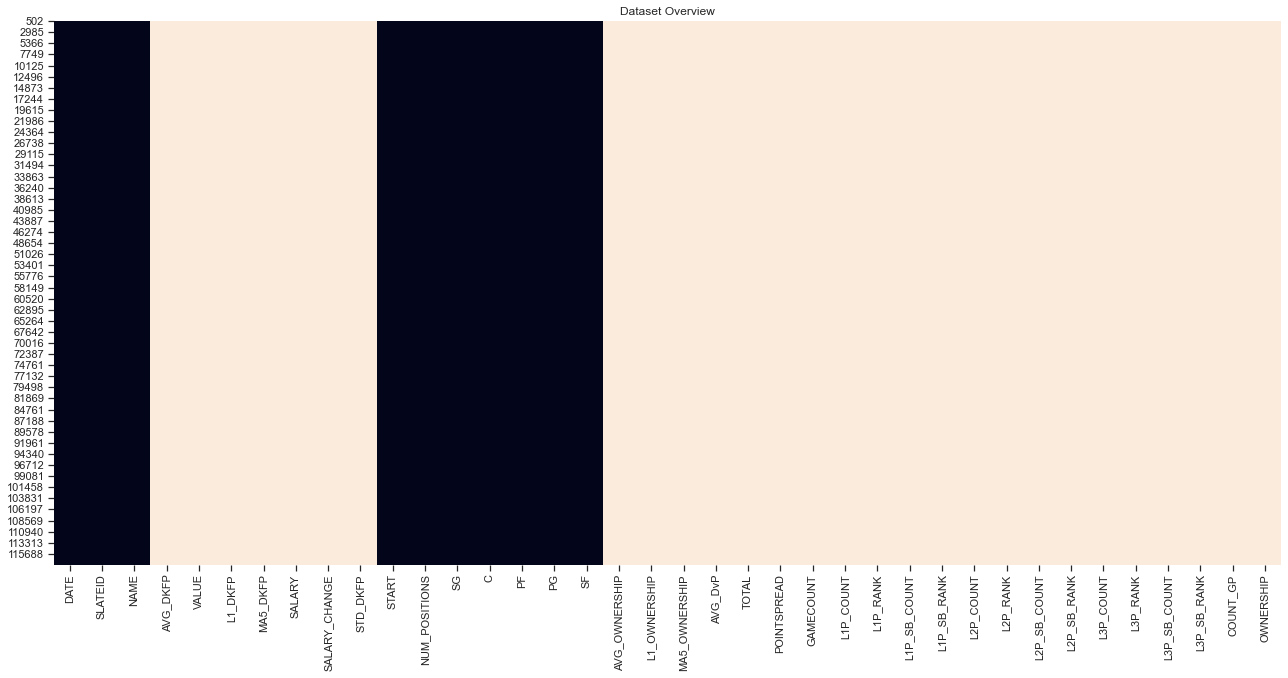

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [24]:
helpers = Helpers()
plt.rcParams["figure.figsize"] = (22, 10)
helpers.visualize_dataframe(feature_matrix)

# Model/Feature Selection
Finally, it's time to build the model. I will iterate through various model types, and choose the model that yeilds the lowest average MSE after 5-fold cross validation.

In [26]:
linear_models = [
    linear_model.LinearRegression()
#     linear_model.Ridge(),
#     linear_model.ElasticNet()
]

neighbor_models = [
#     neighbors.KNeighborsRegressor()
]

boosted_models = [
    xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', learning_rate=0.1, n_estimators=500, tree_method='hist'),
    CatBoostRegressor(eval_metric='MAE', learning_rate=0.1, n_estimators=500, silent=True)
    
]

neural_networks = [
#     neural_network.MLPRegressor(max_iter=10000, early_stopping=True, random_state=42)
]

models = linear_models + neighbor_models + boosted_models + neural_networks

transformer = {
        'Function': lambda x: x,
        'Inverse Function': lambda x: x,
        'Name': 'None'
}

numeric_regressors = list(set(regressors) - set(categorical_regressors))
numeric_columns = numeric_regressors + [y]

min_score = float('inf')
best_model = None
for model in models:
      
    # transform numeric columns
    temp_feature_matrix = feature_matrix.copy()
    temp_feature_matrix[numeric_columns] = temp_feature_matrix[numeric_columns].apply(
        transformer['Function'], axis=1
    )

    # feature selection
    X = temp_feature_matrix[regressors]
    Y = temp_feature_matrix[y]

    if model in (neighbor_models + neural_networks):
        selected_features = regressors.copy()
    else:
        model.fit(X, Y)

        # importance
        importance_selector = SelectFromModel(model, threshold='0.75*median')
        importance_selector = importance_selector.fit(X, Y)
        importance_support = importance_selector.get_support()

        # rank
        rank_selector = RFE(model)
        rank_selector = rank_selector.fit(X, Y)
        rank_support = rank_selector.ranking_
        median_rank = np.median(rank_support)

        selected_features = []
        for feature, importance_flag, rank in zip(list(X.columns), importance_support, rank_support):
            # select the feature if it's important, or has a low rank
            if importance_flag or (rank <= median_rank):
                selected_features.append(feature)

    X = temp_feature_matrix[selected_features].values
    Y = temp_feature_matrix[y].values

    # cross validation
    scores = []
    cv = model_selection.KFold(n_splits=5, shuffle=True)
    for train, test in cv.split(X, Y):
        prediction = model.fit(X[train], Y[train]).predict(X[test])
        true = Y[test]

        prediction = transformer['Inverse Function'](prediction)
        true = transformer['Inverse Function'](true)

        scores.append(metrics.mean_absolute_error(prediction, true))

    mean_score = np.mean(scores)
    print('\nModel:', model)
    print('Transformer:', transformer['Name'])
    print('Selected Features:', selected_features)
    print('Mean MAE:', mean_score)
    if mean_score < min_score:
        min_score = mean_score
        best_model = (model, transformer['Name'], selected_features)

print()
print(best_model, min_score)


Model: LinearRegression()
Transformer: None
Selected Features: ['AVG_DKFP', 'VALUE', 'L1_DKFP', 'MA5_DKFP', 'STD_DKFP', 'START', 'NUM_POSITIONS', 'SG', 'C', 'PF', 'PG', 'SF', 'AVG_OWNERSHIP', 'L1_OWNERSHIP', 'MA5_OWNERSHIP', 'AVG_DvP', 'GAMECOUNT', 'L1P_COUNT', 'L3P_COUNT', 'L3P_SB_COUNT', 'L3P_SB_RANK']
Mean MAE: 0.05635609044086935

Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='hist', validate_parameters=1, verbosity=None)
Transformer: None
Selected Features: ['AVG_DKFP', 'VALUE', 'L1_DKFP', '

# Parameter Tuning
Now, I will use Grid Search Cross Validation to find the CatBoostRegressor paramters that yeild the lowest average MSE on the test set.

In [27]:
selected_features =  ['AVG_DKFP', 'VALUE', 'L1_DKFP', 'MA5_DKFP', 'SALARY', 'SALARY_CHANGE', 'STD_DKFP',
                      'START', 'NUM_POSITIONS', 'SG', 'C', 'PG', 'AVG_OWNERSHIP', 'L1_OWNERSHIP',
                      'MA5_OWNERSHIP', 'AVG_DvP', 'TOTAL', 'POINTSPREAD', 'GAMECOUNT', 'L1P_COUNT',
                      'L1P_RANK', 'L1P_SB_COUNT', 'L1P_SB_RANK', 'L2P_COUNT', 'L3P_COUNT', 'L3P_RANK',
                      'L3P_SB_COUNT', 'L3P_SB_RANK', 'COUNT_GP']
# selected_features = best_model[3]
X = feature_matrix[selected_features]
Y = feature_matrix[y]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

In [29]:
model = xgb.XGBRegressor()

model_params = {
    'max_depth': [6, 8, 10],
    'eta' : [0.01, 0.02, 0.05],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'n_estimators': [2000],
    'eval_metric': ['mae'],
    'tree_method': ['hist']
}

grid = GridSearchCV(estimator=model, param_grid=model_params, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)

fit_params = {
    "early_stopping_rounds": 25,
    "eval_set": [(X_test, y_test)]
}

grid.fit(X_train, y_train, **fit_params)    

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)

print("\n The best score across ALL searched params:\n", grid.best_score_)

print("\n The best parameters across ALL searched params:\n", grid.best_params_)

print("\n ========================================================")

[0]	validation_0-mae:0.41328
Will train until validation_0-mae hasn't improved in 25 rounds.
[1]	validation_0-mae:0.40523
[2]	validation_0-mae:0.39735
[3]	validation_0-mae:0.38962
[4]	validation_0-mae:0.38206
[5]	validation_0-mae:0.37466
[6]	validation_0-mae:0.36741
[7]	validation_0-mae:0.36031
[8]	validation_0-mae:0.35336
[9]	validation_0-mae:0.34654
[10]	validation_0-mae:0.33988
[11]	validation_0-mae:0.33335
[12]	validation_0-mae:0.32695
[13]	validation_0-mae:0.32070
[14]	validation_0-mae:0.31458
[15]	validation_0-mae:0.30857
[16]	validation_0-mae:0.30270
[17]	validation_0-mae:0.29696
[18]	validation_0-mae:0.29132
[19]	validation_0-mae:0.28581
[20]	validation_0-mae:0.28042
[21]	validation_0-mae:0.27514
[22]	validation_0-mae:0.26998
[23]	validation_0-mae:0.26494
[24]	validation_0-mae:0.25998
[25]	validation_0-mae:0.25514
[26]	validation_0-mae:0.25039
[27]	validation_0-mae:0.24576
[28]	validation_0-mae:0.24122
[29]	validation_0-mae:0.23676
[30]	validation_0-mae:0.23241
[31]	validation_

[266]	validation_0-mae:0.03785
[267]	validation_0-mae:0.03783
[268]	validation_0-mae:0.03780
[269]	validation_0-mae:0.03778
[270]	validation_0-mae:0.03775
[271]	validation_0-mae:0.03773
[272]	validation_0-mae:0.03770
[273]	validation_0-mae:0.03767
[274]	validation_0-mae:0.03765
[275]	validation_0-mae:0.03763
[276]	validation_0-mae:0.03760
[277]	validation_0-mae:0.03758
[278]	validation_0-mae:0.03756
[279]	validation_0-mae:0.03753
[280]	validation_0-mae:0.03751
[281]	validation_0-mae:0.03749
[282]	validation_0-mae:0.03747
[283]	validation_0-mae:0.03745
[284]	validation_0-mae:0.03743
[285]	validation_0-mae:0.03741
[286]	validation_0-mae:0.03739
[287]	validation_0-mae:0.03736
[288]	validation_0-mae:0.03734
[289]	validation_0-mae:0.03732
[290]	validation_0-mae:0.03731
[291]	validation_0-mae:0.03729
[292]	validation_0-mae:0.03727
[293]	validation_0-mae:0.03725
[294]	validation_0-mae:0.03724
[295]	validation_0-mae:0.03722
[296]	validation_0-mae:0.03721
[297]	validation_0-mae:0.03719
[298]	va

[531]	validation_0-mae:0.03600
[532]	validation_0-mae:0.03600
[533]	validation_0-mae:0.03600
[534]	validation_0-mae:0.03599
[535]	validation_0-mae:0.03599
[536]	validation_0-mae:0.03599
[537]	validation_0-mae:0.03599
[538]	validation_0-mae:0.03599
[539]	validation_0-mae:0.03598
[540]	validation_0-mae:0.03598
[541]	validation_0-mae:0.03598
[542]	validation_0-mae:0.03598
[543]	validation_0-mae:0.03597
[544]	validation_0-mae:0.03597
[545]	validation_0-mae:0.03597
[546]	validation_0-mae:0.03597
[547]	validation_0-mae:0.03597
[548]	validation_0-mae:0.03597
[549]	validation_0-mae:0.03596
[550]	validation_0-mae:0.03596
[551]	validation_0-mae:0.03596
[552]	validation_0-mae:0.03596
[553]	validation_0-mae:0.03596
[554]	validation_0-mae:0.03595
[555]	validation_0-mae:0.03595
[556]	validation_0-mae:0.03595
[557]	validation_0-mae:0.03594
[558]	validation_0-mae:0.03594
[559]	validation_0-mae:0.03594
[560]	validation_0-mae:0.03594
[561]	validation_0-mae:0.03594
[562]	validation_0-mae:0.03594
[563]	va

[796]	validation_0-mae:0.03545
[797]	validation_0-mae:0.03545
[798]	validation_0-mae:0.03545
[799]	validation_0-mae:0.03545
[800]	validation_0-mae:0.03544
[801]	validation_0-mae:0.03544
[802]	validation_0-mae:0.03544
[803]	validation_0-mae:0.03544
[804]	validation_0-mae:0.03544
[805]	validation_0-mae:0.03543
[806]	validation_0-mae:0.03543
[807]	validation_0-mae:0.03543
[808]	validation_0-mae:0.03543
[809]	validation_0-mae:0.03543
[810]	validation_0-mae:0.03542
[811]	validation_0-mae:0.03542
[812]	validation_0-mae:0.03542
[813]	validation_0-mae:0.03542
[814]	validation_0-mae:0.03542
[815]	validation_0-mae:0.03542
[816]	validation_0-mae:0.03542
[817]	validation_0-mae:0.03541
[818]	validation_0-mae:0.03541
[819]	validation_0-mae:0.03541
[820]	validation_0-mae:0.03541
[821]	validation_0-mae:0.03540
[822]	validation_0-mae:0.03540
[823]	validation_0-mae:0.03540
[824]	validation_0-mae:0.03540
[825]	validation_0-mae:0.03540
[826]	validation_0-mae:0.03540
[827]	validation_0-mae:0.03540
[828]	va

[1059]	validation_0-mae:0.03506
[1060]	validation_0-mae:0.03506
[1061]	validation_0-mae:0.03506
[1062]	validation_0-mae:0.03505
[1063]	validation_0-mae:0.03505
[1064]	validation_0-mae:0.03505
[1065]	validation_0-mae:0.03505
[1066]	validation_0-mae:0.03505
[1067]	validation_0-mae:0.03505
[1068]	validation_0-mae:0.03505
[1069]	validation_0-mae:0.03504
[1070]	validation_0-mae:0.03504
[1071]	validation_0-mae:0.03504
[1072]	validation_0-mae:0.03504
[1073]	validation_0-mae:0.03504
[1074]	validation_0-mae:0.03504
[1075]	validation_0-mae:0.03503
[1076]	validation_0-mae:0.03503
[1077]	validation_0-mae:0.03503
[1078]	validation_0-mae:0.03503
[1079]	validation_0-mae:0.03503
[1080]	validation_0-mae:0.03503
[1081]	validation_0-mae:0.03503
[1082]	validation_0-mae:0.03503
[1083]	validation_0-mae:0.03503
[1084]	validation_0-mae:0.03503
[1085]	validation_0-mae:0.03502
[1086]	validation_0-mae:0.03502
[1087]	validation_0-mae:0.03502
[1088]	validation_0-mae:0.03502
[1089]	validation_0-mae:0.03502
[1090]	v

[1316]	validation_0-mae:0.03475
[1317]	validation_0-mae:0.03475
[1318]	validation_0-mae:0.03475
[1319]	validation_0-mae:0.03474
[1320]	validation_0-mae:0.03474
[1321]	validation_0-mae:0.03474
[1322]	validation_0-mae:0.03474
[1323]	validation_0-mae:0.03474
[1324]	validation_0-mae:0.03474
[1325]	validation_0-mae:0.03474
[1326]	validation_0-mae:0.03474
[1327]	validation_0-mae:0.03473
[1328]	validation_0-mae:0.03473
[1329]	validation_0-mae:0.03473
[1330]	validation_0-mae:0.03473
[1331]	validation_0-mae:0.03473
[1332]	validation_0-mae:0.03473
[1333]	validation_0-mae:0.03473
[1334]	validation_0-mae:0.03472
[1335]	validation_0-mae:0.03472
[1336]	validation_0-mae:0.03472
[1337]	validation_0-mae:0.03472
[1338]	validation_0-mae:0.03472
[1339]	validation_0-mae:0.03472
[1340]	validation_0-mae:0.03472
[1341]	validation_0-mae:0.03472
[1342]	validation_0-mae:0.03472
[1343]	validation_0-mae:0.03472
[1344]	validation_0-mae:0.03472
[1345]	validation_0-mae:0.03471
[1346]	validation_0-mae:0.03472
[1347]	v

[1573]	validation_0-mae:0.03449
[1574]	validation_0-mae:0.03449
[1575]	validation_0-mae:0.03449
[1576]	validation_0-mae:0.03449
[1577]	validation_0-mae:0.03449
[1578]	validation_0-mae:0.03449
[1579]	validation_0-mae:0.03448
[1580]	validation_0-mae:0.03448
[1581]	validation_0-mae:0.03448
[1582]	validation_0-mae:0.03448
[1583]	validation_0-mae:0.03448
[1584]	validation_0-mae:0.03448
[1585]	validation_0-mae:0.03448
[1586]	validation_0-mae:0.03447
[1587]	validation_0-mae:0.03447
[1588]	validation_0-mae:0.03447
[1589]	validation_0-mae:0.03447
[1590]	validation_0-mae:0.03447
[1591]	validation_0-mae:0.03447
[1592]	validation_0-mae:0.03447
[1593]	validation_0-mae:0.03447
[1594]	validation_0-mae:0.03447
[1595]	validation_0-mae:0.03447
[1596]	validation_0-mae:0.03447
[1597]	validation_0-mae:0.03447
[1598]	validation_0-mae:0.03447
[1599]	validation_0-mae:0.03447
[1600]	validation_0-mae:0.03447
[1601]	validation_0-mae:0.03446
[1602]	validation_0-mae:0.03446
[1603]	validation_0-mae:0.03446
[1604]	v

[1830]	validation_0-mae:0.03426
[1831]	validation_0-mae:0.03426
[1832]	validation_0-mae:0.03426
[1833]	validation_0-mae:0.03425
[1834]	validation_0-mae:0.03425
[1835]	validation_0-mae:0.03425
[1836]	validation_0-mae:0.03425
[1837]	validation_0-mae:0.03425
[1838]	validation_0-mae:0.03425
[1839]	validation_0-mae:0.03425
[1840]	validation_0-mae:0.03425
[1841]	validation_0-mae:0.03425
[1842]	validation_0-mae:0.03425
[1843]	validation_0-mae:0.03425
[1844]	validation_0-mae:0.03425
[1845]	validation_0-mae:0.03425
[1846]	validation_0-mae:0.03425
[1847]	validation_0-mae:0.03425
[1848]	validation_0-mae:0.03425
[1849]	validation_0-mae:0.03425
[1850]	validation_0-mae:0.03424
[1851]	validation_0-mae:0.03424
[1852]	validation_0-mae:0.03424
[1853]	validation_0-mae:0.03424
[1854]	validation_0-mae:0.03424
[1855]	validation_0-mae:0.03424
[1856]	validation_0-mae:0.03424
[1857]	validation_0-mae:0.03424
[1858]	validation_0-mae:0.03424
[1859]	validation_0-mae:0.03424
[1860]	validation_0-mae:0.03424
[1861]	v

# Evaluation
Lastly, I will evaluate the final model.

In [30]:
best_params = grid.best_params_
model = xgb.XGBRegressor(**best_params)

model.fit(X_train, y_train, **fit_params)

y_hat = model.predict(X_test)

[0]	validation_0-mae:0.41328
Will train until validation_0-mae hasn't improved in 25 rounds.
[1]	validation_0-mae:0.40523
[2]	validation_0-mae:0.39735
[3]	validation_0-mae:0.38962
[4]	validation_0-mae:0.38206
[5]	validation_0-mae:0.37466
[6]	validation_0-mae:0.36741
[7]	validation_0-mae:0.36031
[8]	validation_0-mae:0.35336
[9]	validation_0-mae:0.34654
[10]	validation_0-mae:0.33988
[11]	validation_0-mae:0.33335
[12]	validation_0-mae:0.32695
[13]	validation_0-mae:0.32070
[14]	validation_0-mae:0.31458
[15]	validation_0-mae:0.30857
[16]	validation_0-mae:0.30270
[17]	validation_0-mae:0.29696
[18]	validation_0-mae:0.29132
[19]	validation_0-mae:0.28581
[20]	validation_0-mae:0.28042
[21]	validation_0-mae:0.27514
[22]	validation_0-mae:0.26998
[23]	validation_0-mae:0.26494
[24]	validation_0-mae:0.25998
[25]	validation_0-mae:0.25514
[26]	validation_0-mae:0.25039
[27]	validation_0-mae:0.24576
[28]	validation_0-mae:0.24122
[29]	validation_0-mae:0.23676
[30]	validation_0-mae:0.23241
[31]	validation_

[266]	validation_0-mae:0.03785
[267]	validation_0-mae:0.03783
[268]	validation_0-mae:0.03780
[269]	validation_0-mae:0.03778
[270]	validation_0-mae:0.03775
[271]	validation_0-mae:0.03773
[272]	validation_0-mae:0.03770
[273]	validation_0-mae:0.03767
[274]	validation_0-mae:0.03765
[275]	validation_0-mae:0.03763
[276]	validation_0-mae:0.03760
[277]	validation_0-mae:0.03758
[278]	validation_0-mae:0.03756
[279]	validation_0-mae:0.03753
[280]	validation_0-mae:0.03751
[281]	validation_0-mae:0.03749
[282]	validation_0-mae:0.03747
[283]	validation_0-mae:0.03745
[284]	validation_0-mae:0.03743
[285]	validation_0-mae:0.03741
[286]	validation_0-mae:0.03739
[287]	validation_0-mae:0.03736
[288]	validation_0-mae:0.03734
[289]	validation_0-mae:0.03732
[290]	validation_0-mae:0.03731
[291]	validation_0-mae:0.03729
[292]	validation_0-mae:0.03727
[293]	validation_0-mae:0.03725
[294]	validation_0-mae:0.03724
[295]	validation_0-mae:0.03722
[296]	validation_0-mae:0.03721
[297]	validation_0-mae:0.03719
[298]	va

[531]	validation_0-mae:0.03600
[532]	validation_0-mae:0.03600
[533]	validation_0-mae:0.03600
[534]	validation_0-mae:0.03599
[535]	validation_0-mae:0.03599
[536]	validation_0-mae:0.03599
[537]	validation_0-mae:0.03599
[538]	validation_0-mae:0.03599
[539]	validation_0-mae:0.03598
[540]	validation_0-mae:0.03598
[541]	validation_0-mae:0.03598
[542]	validation_0-mae:0.03598
[543]	validation_0-mae:0.03597
[544]	validation_0-mae:0.03597
[545]	validation_0-mae:0.03597
[546]	validation_0-mae:0.03597
[547]	validation_0-mae:0.03597
[548]	validation_0-mae:0.03597
[549]	validation_0-mae:0.03596
[550]	validation_0-mae:0.03596
[551]	validation_0-mae:0.03596
[552]	validation_0-mae:0.03596
[553]	validation_0-mae:0.03596
[554]	validation_0-mae:0.03595
[555]	validation_0-mae:0.03595
[556]	validation_0-mae:0.03595
[557]	validation_0-mae:0.03594
[558]	validation_0-mae:0.03594
[559]	validation_0-mae:0.03594
[560]	validation_0-mae:0.03594
[561]	validation_0-mae:0.03594
[562]	validation_0-mae:0.03594
[563]	va

[796]	validation_0-mae:0.03545
[797]	validation_0-mae:0.03545
[798]	validation_0-mae:0.03545
[799]	validation_0-mae:0.03545
[800]	validation_0-mae:0.03544
[801]	validation_0-mae:0.03544
[802]	validation_0-mae:0.03544
[803]	validation_0-mae:0.03544
[804]	validation_0-mae:0.03544
[805]	validation_0-mae:0.03543
[806]	validation_0-mae:0.03543
[807]	validation_0-mae:0.03543
[808]	validation_0-mae:0.03543
[809]	validation_0-mae:0.03543
[810]	validation_0-mae:0.03542
[811]	validation_0-mae:0.03542
[812]	validation_0-mae:0.03542
[813]	validation_0-mae:0.03542
[814]	validation_0-mae:0.03542
[815]	validation_0-mae:0.03542
[816]	validation_0-mae:0.03542
[817]	validation_0-mae:0.03541
[818]	validation_0-mae:0.03541
[819]	validation_0-mae:0.03541
[820]	validation_0-mae:0.03541
[821]	validation_0-mae:0.03540
[822]	validation_0-mae:0.03540
[823]	validation_0-mae:0.03540
[824]	validation_0-mae:0.03540
[825]	validation_0-mae:0.03540
[826]	validation_0-mae:0.03540
[827]	validation_0-mae:0.03540
[828]	va

[1059]	validation_0-mae:0.03506
[1060]	validation_0-mae:0.03506
[1061]	validation_0-mae:0.03506
[1062]	validation_0-mae:0.03505
[1063]	validation_0-mae:0.03505
[1064]	validation_0-mae:0.03505
[1065]	validation_0-mae:0.03505
[1066]	validation_0-mae:0.03505
[1067]	validation_0-mae:0.03505
[1068]	validation_0-mae:0.03505
[1069]	validation_0-mae:0.03504
[1070]	validation_0-mae:0.03504
[1071]	validation_0-mae:0.03504
[1072]	validation_0-mae:0.03504
[1073]	validation_0-mae:0.03504
[1074]	validation_0-mae:0.03504
[1075]	validation_0-mae:0.03503
[1076]	validation_0-mae:0.03503
[1077]	validation_0-mae:0.03503
[1078]	validation_0-mae:0.03503
[1079]	validation_0-mae:0.03503
[1080]	validation_0-mae:0.03503
[1081]	validation_0-mae:0.03503
[1082]	validation_0-mae:0.03503
[1083]	validation_0-mae:0.03503
[1084]	validation_0-mae:0.03503
[1085]	validation_0-mae:0.03502
[1086]	validation_0-mae:0.03502
[1087]	validation_0-mae:0.03502
[1088]	validation_0-mae:0.03502
[1089]	validation_0-mae:0.03502
[1090]	v

[1316]	validation_0-mae:0.03475
[1317]	validation_0-mae:0.03475
[1318]	validation_0-mae:0.03475
[1319]	validation_0-mae:0.03474
[1320]	validation_0-mae:0.03474
[1321]	validation_0-mae:0.03474
[1322]	validation_0-mae:0.03474
[1323]	validation_0-mae:0.03474
[1324]	validation_0-mae:0.03474
[1325]	validation_0-mae:0.03474
[1326]	validation_0-mae:0.03474
[1327]	validation_0-mae:0.03473
[1328]	validation_0-mae:0.03473
[1329]	validation_0-mae:0.03473
[1330]	validation_0-mae:0.03473
[1331]	validation_0-mae:0.03473
[1332]	validation_0-mae:0.03473
[1333]	validation_0-mae:0.03473
[1334]	validation_0-mae:0.03472
[1335]	validation_0-mae:0.03472
[1336]	validation_0-mae:0.03472
[1337]	validation_0-mae:0.03472
[1338]	validation_0-mae:0.03472
[1339]	validation_0-mae:0.03472
[1340]	validation_0-mae:0.03472
[1341]	validation_0-mae:0.03472
[1342]	validation_0-mae:0.03472
[1343]	validation_0-mae:0.03472
[1344]	validation_0-mae:0.03472
[1345]	validation_0-mae:0.03471
[1346]	validation_0-mae:0.03472
[1347]	v

[1573]	validation_0-mae:0.03449
[1574]	validation_0-mae:0.03449
[1575]	validation_0-mae:0.03449
[1576]	validation_0-mae:0.03449
[1577]	validation_0-mae:0.03449
[1578]	validation_0-mae:0.03449
[1579]	validation_0-mae:0.03448
[1580]	validation_0-mae:0.03448
[1581]	validation_0-mae:0.03448
[1582]	validation_0-mae:0.03448
[1583]	validation_0-mae:0.03448
[1584]	validation_0-mae:0.03448
[1585]	validation_0-mae:0.03448
[1586]	validation_0-mae:0.03447
[1587]	validation_0-mae:0.03447
[1588]	validation_0-mae:0.03447
[1589]	validation_0-mae:0.03447
[1590]	validation_0-mae:0.03447
[1591]	validation_0-mae:0.03447
[1592]	validation_0-mae:0.03447
[1593]	validation_0-mae:0.03447
[1594]	validation_0-mae:0.03447
[1595]	validation_0-mae:0.03447
[1596]	validation_0-mae:0.03447
[1597]	validation_0-mae:0.03447
[1598]	validation_0-mae:0.03447
[1599]	validation_0-mae:0.03447
[1600]	validation_0-mae:0.03447
[1601]	validation_0-mae:0.03446
[1602]	validation_0-mae:0.03446
[1603]	validation_0-mae:0.03446
[1604]	v

[1830]	validation_0-mae:0.03426
[1831]	validation_0-mae:0.03426
[1832]	validation_0-mae:0.03426
[1833]	validation_0-mae:0.03425
[1834]	validation_0-mae:0.03425
[1835]	validation_0-mae:0.03425
[1836]	validation_0-mae:0.03425
[1837]	validation_0-mae:0.03425
[1838]	validation_0-mae:0.03425
[1839]	validation_0-mae:0.03425
[1840]	validation_0-mae:0.03425
[1841]	validation_0-mae:0.03425
[1842]	validation_0-mae:0.03425
[1843]	validation_0-mae:0.03425
[1844]	validation_0-mae:0.03425
[1845]	validation_0-mae:0.03425
[1846]	validation_0-mae:0.03425
[1847]	validation_0-mae:0.03425
[1848]	validation_0-mae:0.03425
[1849]	validation_0-mae:0.03425
[1850]	validation_0-mae:0.03424
[1851]	validation_0-mae:0.03424
[1852]	validation_0-mae:0.03424
[1853]	validation_0-mae:0.03424
[1854]	validation_0-mae:0.03424
[1855]	validation_0-mae:0.03424
[1856]	validation_0-mae:0.03424
[1857]	validation_0-mae:0.03424
[1858]	validation_0-mae:0.03424
[1859]	validation_0-mae:0.03424
[1860]	validation_0-mae:0.03424
[1861]	v

First, I will visualize the feature importances.

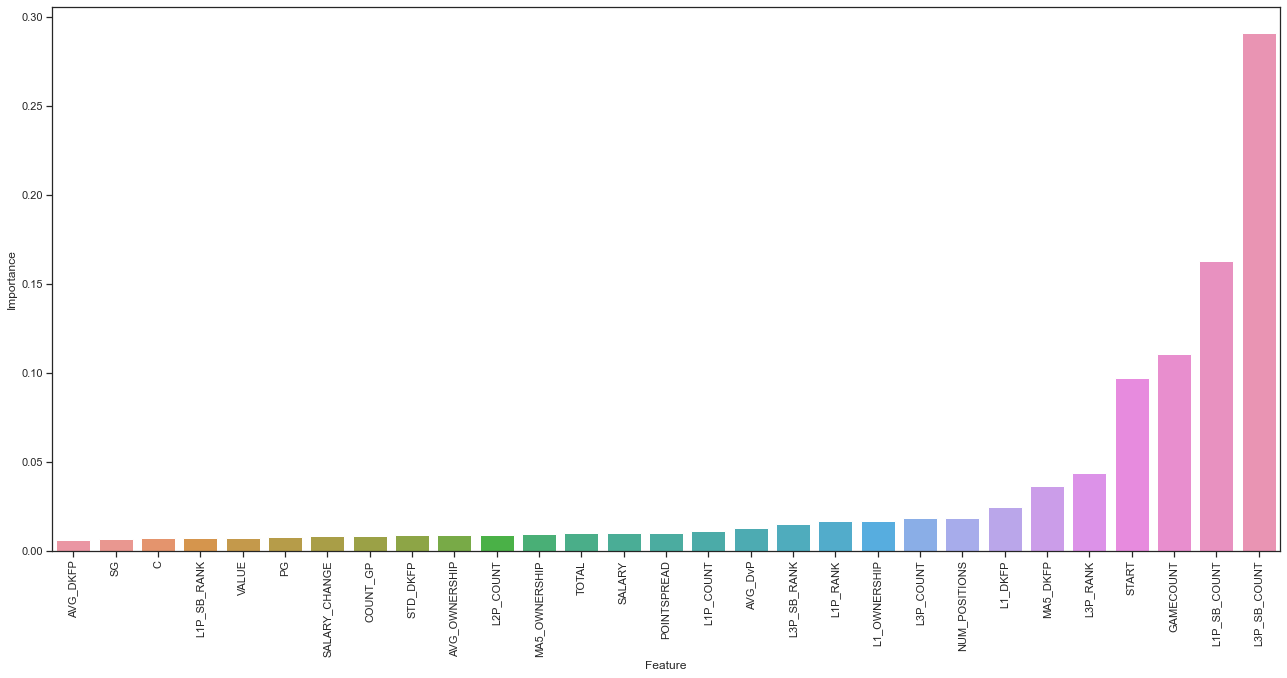

In [31]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Importance': feature_importances, 'Feature': selected_features})
feature_importance_df = feature_importance_df.sort_values(by='Importance')
ax = sns.barplot(x="Feature", y="Importance", data=feature_importance_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

I will calculate a few metrics to evaluate the model's predictive power.

In [32]:
y_avg = feature_matrix.loc[X_test.index, 'AVG_OWNERSHIP']

# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(y_test, y_hat), 3))
print("Baseline:", round(metrics.r2_score(y_test, y_avg), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(y_test, y_hat), 6))
print("Baseline:", round(metrics.mean_absolute_error(y_test, y_avg), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(y_test, y_hat)), 6))
print("Baseline:", round(np.sqrt(metrics.mean_squared_error(y_test, y_avg)), 6))

R2 (explained variance):
Model: 0.764
Baseline: 0.306

Mean Absolute Error (Σ|y-pred|/n):
Model: 0.034137
Baseline: 0.063603

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 0.063607
Baseline: 0.108977


Residual analysis:

No handles with labels found to put in legend.
No handles with labels found to put in legend.


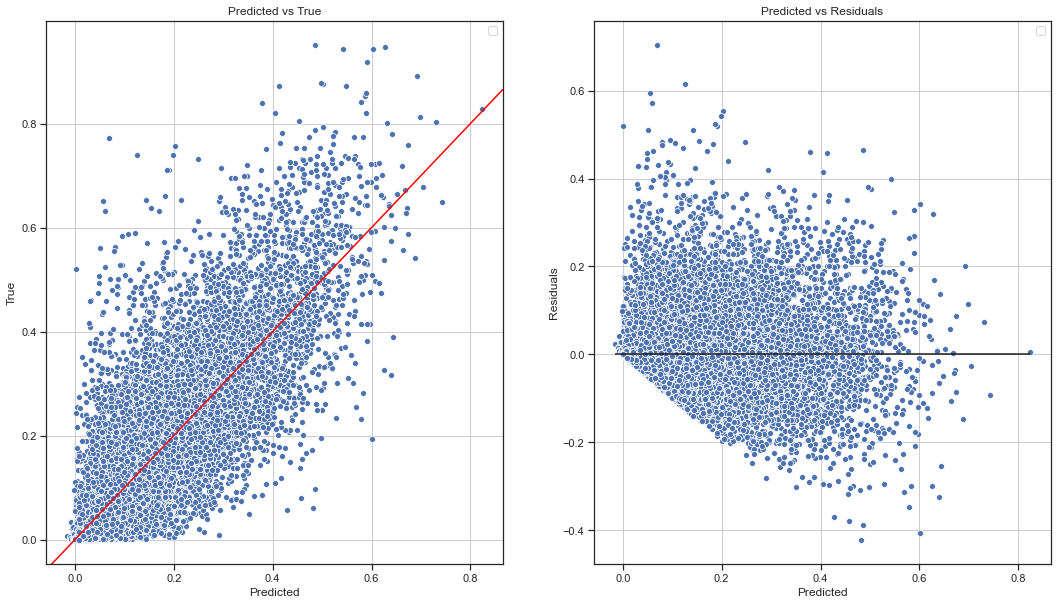

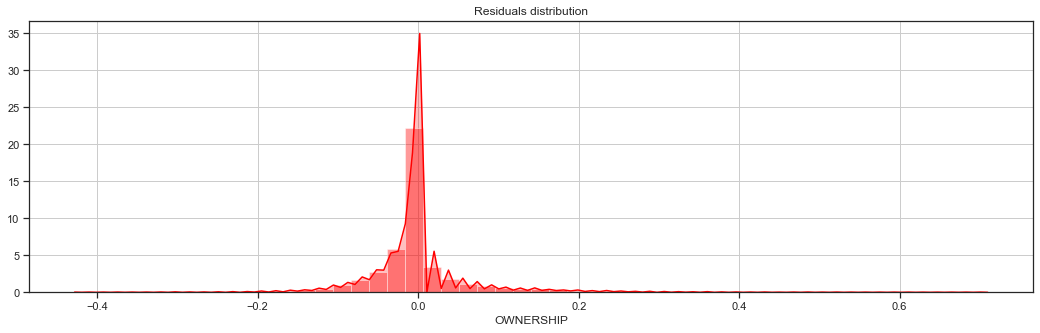

In [33]:
residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
sns.scatterplot(y_hat, y_test, ax=ax[0])
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
sns.scatterplot(y_hat, residuals, ax=ax[1])
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

fig, ax = plt.subplots(figsize=(18, 5))
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(title="Residuals distribution")
plt.show()

In [ ]:
stat, p = shapiro(residuals)
print(stat, p)

Residuals are normally distributed and not heteroskedastic.

In [35]:
feature_matrix.loc[X_test.index, 'RESULT'] = y_hat
display(feature_matrix.loc[X_test.index, ['DATE', 'NAME', 'GAMECOUNT', 'OWNERSHIP', 'RESULT']].sort_values(by=['DATE', 'NAME']))

,DATE,NAME,GAMECOUNT,OWNERSHIP,RESULT
631,2017-10-20,Al-Farouq Aminu,10,0.010132,0.043333
632,2017-10-20,Alec Burks,10,0.004034,0.004021
503,2017-10-20,Alec Peters,10,0.001091,0.000561
637,2017-10-20,Andre Drummond,10,0.050668,0.050667
511,2017-10-20,Andrew Bogut,2,0.004916,0.012940
639,2017-10-20,Andrew Wiggins,2,0.623468,0.484636
515,2017-10-20,Anthony Davis,2,0.472300,0.442116
513,2017-10-20,Anthony Davis,2,0.436865,0.455121
642,2017-10-20,Arron Afflalo,10,0.001233,-0.000038
647,2017-10-20,Bradley Beal,10,0.055385,0.122563


In [ ]:
display(contests.loc[(contests['SLATEID'] == '5ae4cbe2c074cf3dff32fa1b')])